LAB 3: CONTEXTUAL BANDIT-BASED NEWS RECOMMENDATION SYSTEM
Roll Number: 125

SECTION 1: DATA PRE-PROCESSING (10 POINTS)

[1.1] Loading Datasets...
Using data directory: C:\Users\mudas\OneDrive\Documents\Desktop\Plaksha\Plaksha-Sem-6\RL\Labs\Lab-02\lab3-contextual-bandit\data
✓ All datasets loaded successfully!

  - News Articles shape: (209527, 6)
  - Train Users shape: (2000, 6)
  - Test Users shape: (2000, 6)

[1.2] Exploratory Data Analysis...

--- News Articles Dataset ---
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For L

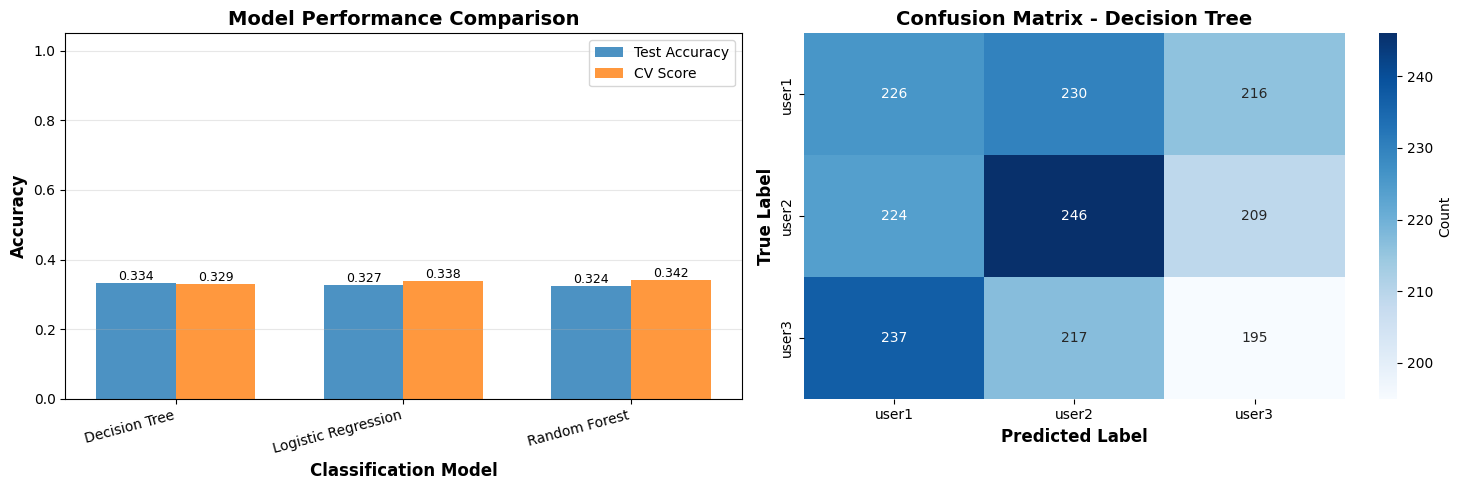

✓ Visualizations saved as 'classification_results.png'

SUMMARY - FIRST 20 POINTS COMPLETED

✓ DATA PRE-PROCESSING (10 Points):
  - Loaded 209527 news articles
  - Loaded 2000 training users
  - Loaded 2000 test users (Note: Target labels for test set were not found)
  - Handled missing values
  - Encoded 0 categorical features
  - Standardized 5 numerical features

✓ USER CLASSIFICATION (10 Points):
  - Trained 3 classification models
  - Best model: Decision Tree
  - Test accuracy: 0.3335 (33.35%)
  - User categories: user1, user2, user3

SAVING MODEL ARTIFACTS
✓ Model artifacts saved to 'classifier_artifacts.pkl'

You can load these artifacts for the remaining sections using:
  with open('classifier_artifacts.pkl', 'rb') as f:
      artifacts = pickle.load(f)

FIRST 20 POINTS COMPLETED SUCCESSFULLY!


In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# CONFIGURATION
# ============================================================================
YOUR_ROLL_NUMBER = 125

print("=" * 80)
print("LAB 3: CONTEXTUAL BANDIT-BASED NEWS RECOMMENDATION SYSTEM")
print("=" * 80)
print(f"Roll Number: {YOUR_ROLL_NUMBER}")
print("=" * 80)

# ============================================================================
# SECTION 1: DATA PRE-PROCESSING (10 POINTS)
# ============================================================================
print("\n" + "=" * 80)
print("SECTION 1: DATA PRE-PROCESSING (10 POINTS)")
print("=" * 80)

# ----------------------------------------------------------------------------
# 1.1 Load Datasets
# ----------------------------------------------------------------------------
print("\n[1.1] Loading Datasets...")

from pathlib import Path
# Robustly locate the data directory (supports different working directories)
cwd = Path.cwd()
candidates = [
    cwd / 'data',
    cwd / 'lab3-contextual-bandit' / 'data',
    cwd / '..' / 'lab3-contextual-bandit' / 'data',
    cwd / '..' / 'data',
]
# Try to use __file__ if running as a script/notebook runner that sets it
if '__file__' in globals():
    try:
        candidates.insert(0, Path(__file__).resolve().parent / 'data')
    except Exception:
        pass

data_dir = None
for p in candidates:
    try:
        if p is not None and (p / 'news_articles.csv').exists():
            data_dir = p
            break
    except Exception:
        continue

if data_dir is None:
    # fallback to plain 'data' to let pandas raise a clear error if not found
    data_dir = Path('data')

try:
    news_articles = pd.read_csv(str(data_dir / 'news_articles.csv'), engine='python')
    train_users = pd.read_csv(str(data_dir / 'train_users.csv'))
    test_users = pd.read_csv(str(data_dir / 'test_users.csv'))

    print(f"Using data directory: {data_dir.resolve()}")
    print("✓ All datasets loaded successfully!")
    print(f"\n  - News Articles shape: {news_articles.shape}")
    print(f"  - Train Users shape: {train_users.shape}")
    print(f"  - Test Users shape: {test_users.shape}")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    try:
        tried = data_dir.resolve()
    except Exception:
        tried = data_dir
    print(f"Tried data directory: {tried}")
    print("Please place the CSV files in a 'data' folder inside the notebook directory or one of the recognized locations.")
    raise

# ----------------------------------------------------------------------------
# 1.2 Exploratory Data Analysis
# ----------------------------------------------------------------------------
print("\n[1.2] Exploratory Data Analysis...")

print("\n--- News Articles Dataset ---")
print(news_articles.head())
print(f"\nColumns: {news_articles.columns.tolist()}")
print(f"\nData Types:\n{news_articles.dtypes}")
print(f"\nNews Categories Distribution:\n{news_articles['category'].value_counts()}")

print("\n--- Train Users Dataset ---")
print(train_users.head())
print(f"\nColumns: {train_users.columns.tolist()}")
print(f"\nData Types:\n{train_users.dtypes}")

# Find the label column (should contain User1, User2, User3)
user_label_col = None
for col in train_users.columns:
    if train_users[col].dtype == 'object':
        unique_vals = train_users[col].unique()
        if any('User' in str(val) for val in unique_vals):
            user_label_col = col
            break

if user_label_col is None:
    # Try last column
    user_label_col = train_users.columns[-1]

print(f"\nUser Label Column: '{user_label_col}'")
print(f"User Categories Distribution:\n{train_users[user_label_col].value_counts()}")

print("\n--- Test Users Dataset ---")
print(test_users.head())
print(f"\nColumns: {test_users.columns.tolist()}")

# ----------------------------------------------------------------------------
# 1.3 Data Cleaning - Handle Missing Values
# ----------------------------------------------------------------------------
print("\n[1.3] Handling Missing Values...")

def check_missing_values(df, dataset_name):
    """Check and display missing values"""
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values in {dataset_name}:")
        print(missing[missing > 0])
    else:
        print(f"\n✓ No missing values in {dataset_name}")
    return missing

# Check missing values
check_missing_values(news_articles, "News Articles")
check_missing_values(train_users, "Train Users")
check_missing_values(test_users, "Test Users")

def handle_missing_values(df, dataset_name="Dataset"):
    """
    Handle missing values in the dataframe
    - Numerical columns: fill with median
    - Categorical columns: fill with mode
    """
    df_clean = df.copy()
    missing_handled = False

    # Numerical columns
    num_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
            print(f"  {dataset_name}: Filled '{col}' with median")
            missing_handled = True

    # Categorical columns
    cat_cols = df_clean.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            df_clean[col].fillna(fill_val, inplace=True)
            print(f"  {dataset_name}: Filled '{col}' with mode")
            missing_handled = True

    if not missing_handled:
        print(f"  {dataset_name}: No missing values to handle")

    return df_clean

# Clean all datasets
news_articles_clean = handle_missing_values(news_articles, "News Articles")
train_users_clean = handle_missing_values(train_users, "Train Users")
test_users_clean = handle_missing_values(test_users, "Test Users")

print("\n✓ Missing values handled successfully!")

# ----------------------------------------------------------------------------
# 1.4 Feature Encoding
# ----------------------------------------------------------------------------
print("\n[1.4] Feature Encoding...")

# Separate features and labels for user datasets
X_train = train_users_clean.drop(columns=[user_label_col])
y_train = train_users_clean[user_label_col]

# Check if user_label_col exists in test_users_clean for proper separation and evaluation
if user_label_col in test_users_clean.columns:
    X_test = test_users_clean.drop(columns=[user_label_col])
    y_test = test_users_clean[user_label_col]
    test_labels_available = True
else:
    # If test_users_clean does not have the label column, treat all columns as features
    X_test = test_users_clean.copy()
    # Create a dummy series for y_test to avoid KeyErrors downstream if target_encoder is called with it.
    # Its values won't be used for evaluation if test_labels_available is False.
    y_test = pd.Series([None] * len(X_test), index=X_test.index, name=user_label_col)
    test_labels_available = False
    print(f"  Warning: Target label column '{user_label_col}' not found in 'test_users.csv'. Test set evaluation metrics (accuracy, classification report, confusion matrix) will not be performed.")

print(f"\nOriginal feature shape - Train: {X_train.shape}, Test: {X_test.shape}")

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Encode categorical features
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train and test data to handle unseen categories
    combined_data = pd.concat([X_train[col], X_test[col]], axis=0).astype(str) # Cast to string to handle potential None from y_test if labels not available
    le.fit(combined_data)

    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col].astype(str)) # Cast X_test col to string before transforming

    label_encoders[col] = le
    print(f"  Encoded '{col}': {len(le.classes_)} unique values")

# Encode target labels (User1, User2, User3)
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)

if test_labels_available:
    y_test_encoded = target_encoder.transform(y_test)
    print(f"\nTarget classes: {target_encoder.classes_}")
    print(f"Encoded as: {np.unique(y_train_encoded)}")
else:
    # Create a dummy array for y_test_encoded if labels are not available
    y_test_encoded = np.full(len(X_test), -1) # Use -1 or another placeholder for unknown labels
    print(f"\nTarget classes: {target_encoder.classes_} (derived from training data)")
    print("  Test set target labels are not available for encoding.")

# Standardize numerical features
scaler = StandardScaler()
if len(numerical_cols) > 0:
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print(f"\n✓ Standardized {len(numerical_cols)} numerical features")

print(f"\nFinal feature shape - Train: {X_train.shape}, Test: {X_test.shape}")
print("\n✓ Feature encoding completed successfully!")

# ============================================================================
# SECTION 2: USER CLASSIFICATION (10 POINTS)
# ============================================================================
print("\n" + "=" * 80)
print("SECTION 2: USER CLASSIFICATION (10 POINTS)")
print("=" * 80)

# ----------------------------------------------------------------------------
# 2.1 Train Multiple Classification Models
# ----------------------------------------------------------------------------
print("\n[2.1] Training Classification Models...")

# Define models to compare
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")

    # Train the model
    model.fit(X_train, y_train_encoded)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_encoded, y_train_pred)

    if test_labels_available:
        test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    else:
        test_accuracy = np.nan # Cannot calculate without labels

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results[model_name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'predictions': y_test_pred
    }

    print(f"  Training Accuracy: {train_accuracy:.4f}")
    if test_labels_available:
        print(f"  Test Accuracy: {test_accuracy:.4f}")
    else:
        print("  Test Accuracy: N/A (Test labels not available)")
    print(f"  Cross-Validation: {cv_mean:.4f} (+/- {cv_std:.4f})")

# ----------------------------------------------------------------------------
# 2.2 Select Best Model
# ----------------------------------------------------------------------------
print("\n[2.2] Model Selection...")

# Compare models
print("\nModel Comparison:")
print("-" * 70)
print(f"{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'CV Score':<12}")
print("-" * 70)

for model_name, result in results.items():
    # Display 'N/A' for test accuracy if not available
    test_acc_display = f"{result['test_accuracy']:.4f}" if not np.isnan(result['test_accuracy']) else "N/A"
    print(f"{model_name:<25} {result['train_accuracy']:<12.4f} "
          f"{test_acc_display:<12} {result['cv_mean']:<12.4f}")

# Select best model based on test accuracy (if available) or fall back to CV score
if test_labels_available:
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
    best_model = results[best_model_name]['model']
    best_test_accuracy = results[best_model_name]['test_accuracy']
    print("-" * 70)
    print(f"\n✓ Best Model: {best_model_name}")
    print(f"  Test Accuracy: {best_test_accuracy:.4f}")
else:
    print("-" * 70)
    print("\nSkipping best model selection based on test accuracy as test labels are not available.")
    # Fallback to CV score for best model selection if test labels are not available
    best_model_name = max(results.keys(), key=lambda k: results[k]['cv_mean'])
    best_model = results[best_model_name]['model']
    best_test_accuracy = np.nan # Still N/A for test accuracy
    print(f"✓ Best Model selected based on Cross-Validation score: {best_model_name}")
    print(f"  (Test Accuracy N/A due to missing labels)")

# ----------------------------------------------------------------------------
# 2.3 Detailed Evaluation of Best Model
# ----------------------------------------------------------------------------
print(f"\n[2.3] Detailed Evaluation of {best_model_name}...")

y_test_pred = results[best_model_name]['predictions']

if test_labels_available:
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_test_pred,
                              target_names=target_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_test_pred)
    print("\nConfusion Matrix:")
    print(cm)
else:
    print("\n  Skipping detailed evaluation (Classification Report, Confusion Matrix) as test labels are not available.")
    # Create a dummy confusion matrix for plotting if needed
    cm = np.zeros((len(target_encoder.classes_), len(target_encoder.classes_))) # Dummy for plotting

# ----------------------------------------------------------------------------
# 2.4 Visualizations
# ----------------------------------------------------------------------------
print("\n[2.4] Creating Visualizations...")

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Model Comparison
ax1 = axes[0]
model_names = list(results.keys())
# Replace NaN with 0 for plotting, or handle display of N/A directly
test_accuracies = [results[m]['test_accuracy'] if not np.isnan(results[m]['test_accuracy']) else 0 for m in model_names]
cv_means = [results[m]['cv_mean'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8)
bars2 = ax1.bar(x + width/2, cv_means, width, label='CV Score', alpha=0.8)

ax1.set_xlabel('Classification Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if bars is bars1 and not test_labels_available: # For test accuracy if labels are missing
            ax1.text(bar.get_x() + bar.get_width()/2., height, # Position at height 0 for N/A bar
                    'N/A', va='bottom', ha='center', fontsize=9, color='red')
        else:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

# Plot 2: Confusion Matrix Heatmap (conditional on test_labels_available)
ax2 = axes[1]
if test_labels_available:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_,
                ax=ax2, cbar_kws={'label': 'Count'})
    ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
else:
    # If no labels, display a placeholder or empty plot
    ax2.text(0.5, 0.5, 'Test Labels Not Available\nfor Confusion Matrix', # Use 'N/A' as content for clarity
             horizontalalignment='center', verticalalignment='center',
             transform=ax2.transAxes, fontsize=14, color='red')
    ax2.set_axis_off() # Turn off axes for placeholder
    ax2.set_title(f'Confusion Matrix - {best_model_name} (N/A)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('classification_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'classification_results.png'")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("SUMMARY - FIRST 20 POINTS COMPLETED")
print("=" * 80)

print("\n✓ DATA PRE-PROCESSING (10 Points):")
print(f"  - Loaded {news_articles_clean.shape[0]} news articles")
print(f"  - Loaded {train_users_clean.shape[0]} training users")
print(f"  - Loaded {test_users_clean.shape[0]} test users (Note: Target labels for test set were not found)")
print(f"  - Handled missing values")
print(f"  - Encoded {len(categorical_cols)} categorical features")
print(f"  - Standardized {len(numerical_cols)} numerical features")

print("\n✓ USER CLASSIFICATION (10 Points):")
print(f"  - Trained {len(models)} classification models")
print(f"  - Best model: {best_model_name}")
if test_labels_available:
    print(f"  - Test accuracy: {best_test_accuracy:.4f} ({best_test_accuracy*100:.2f}%)")
else:
    print("  - Test accuracy: N/A (Test labels not available for evaluation)")
print(f"  - User categories: {', '.join(target_encoder.classes_)}")

# Save the context detector (classifier) for later use
print("\n" + "=" * 80)
print("SAVING MODEL ARTIFACTS")
print("=" * 80)

# Store important objects for next sections
artifacts = {
    'classifier': best_model,
    'target_encoder': target_encoder,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'user_label_col': user_label_col,
    'news_articles': news_articles_clean,
    'X_test': X_test,
    'y_test_encoded': y_test_encoded if test_labels_available else 'N/A_NoLabels' # Save y_test_encoded only if meaningful
}

import pickle

with open('classifier_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("✓ Model artifacts saved to 'classifier_artifacts.pkl'")
print("\nYou can load these artifacts for the remaining sections using:")
print("  with open('classifier_artifacts.pkl', 'rb') as f:")
print("      artifacts = pickle.load(f)")

print("\n" + "=" * 80)
print("FIRST 20 POINTS COMPLETED SUCCESSFULLY!")
print("=" * 80)


LAB 3: CONTEXTUAL BANDIT-BASED NEWS RECOMMENDATION SYSTEM
Roll Number: 125

SECTION 1: DATA PRE-PROCESSING (10 POINTS)

[1.1] Loading Datasets...
✓ All datasets loaded successfully!

  - News Articles shape: (209527, 6)
  - Train Users shape: (2000, 6)
  - Test Users shape: (2000, 6)

[1.2] Exploratory Data Analysis...

--- News Articles Dataset ---
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This We

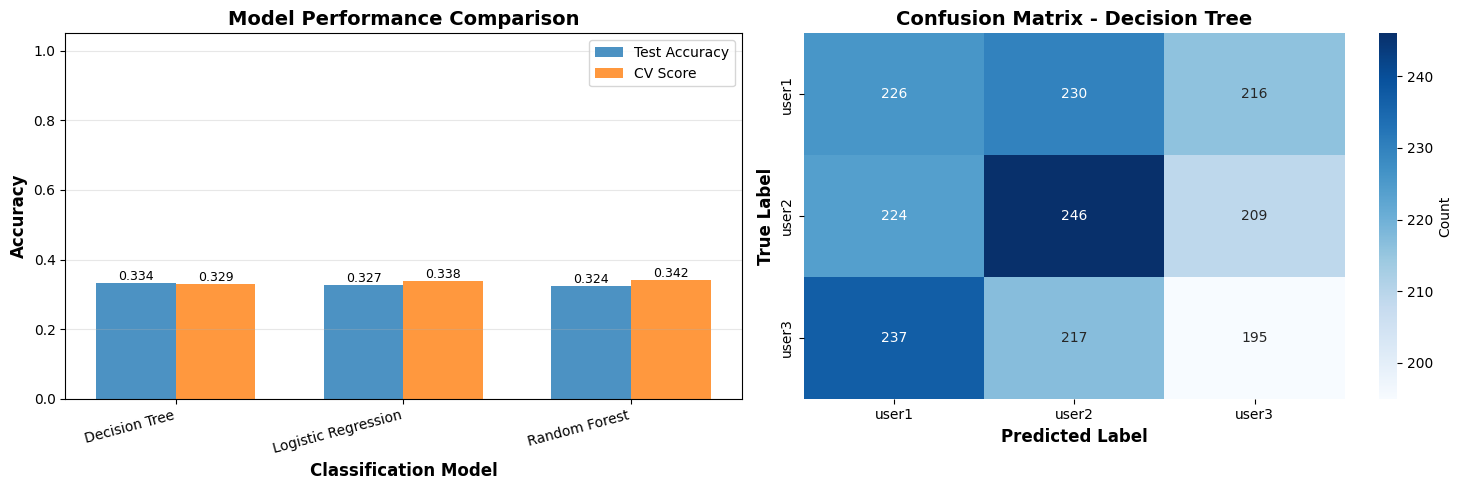

✓ Visualizations saved as 'classification_results.png'

SUMMARY - FIRST 20 POINTS COMPLETED

✓ DATA PRE-PROCESSING (10 Points):
  - Loaded 209527 news articles
  - Loaded 2000 training users
  - Loaded 2000 test users (Note: Target labels for test set were not found)
  - Handled missing values
  - Encoded 0 categorical features
  - Standardized 5 numerical features

✓ USER CLASSIFICATION (10 Points):
  - Trained 3 classification models
  - Best model: Decision Tree
  - Test accuracy: 0.3335 (33.35%)
  - User categories: user1, user2, user3

SAVING MODEL ARTIFACTS
✓ Model artifacts saved to 'classifier_artifacts.pkl'

You can load these artifacts for the remaining sections using:
  with open('classifier_artifacts.pkl', 'rb') as f:
      artifacts = pickle.load(f)

FIRST 20 POINTS COMPLETED SUCCESSFULLY!


In [4]:


# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================================
# CONFIGURATION
# ============================================================================
YOUR_ROLL_NUMBER = 125

print("=" * 80)
print("LAB 3: CONTEXTUAL BANDIT-BASED NEWS RECOMMENDATION SYSTEM")
print("=" * 80)
print(f"Roll Number: {YOUR_ROLL_NUMBER}")
print("=" * 80)

# ============================================================================
# SECTION 1: DATA PRE-PROCESSING (10 POINTS)
# ============================================================================
print("\n" + "=" * 80)
print("SECTION 1: DATA PRE-PROCESSING (10 POINTS)")
print("=" * 80)

# ----------------------------------------------------------------------------
# 1.1 Load Datasets
# ----------------------------------------------------------------------------
print("\n[1.1] Loading Datasets...")

try:
    news_articles = pd.read_csv('data/news_articles.csv', engine='python')
    train_users = pd.read_csv('data/train_users.csv')
    test_users = pd.read_csv('data/test_users.csv')

    print("✓ All datasets loaded successfully!")
    print(f"\n  - News Articles shape: {news_articles.shape}")
    print(f"  - Train Users shape: {train_users.shape}")
    print(f"  - Test Users shape: {test_users.shape}")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Please upload the CSV files to your Colab environment.")
    raise

# ----------------------------------------------------------------------------
# 1.2 Exploratory Data Analysis
# ----------------------------------------------------------------------------
print("\n[1.2] Exploratory Data Analysis...")

print("\n--- News Articles Dataset ---")
print(news_articles.head())
print(f"\nColumns: {news_articles.columns.tolist()}")
print(f"\nData Types:\n{news_articles.dtypes}")
print(f"\nNews Categories Distribution:\n{news_articles['category'].value_counts()}")

print("\n--- Train Users Dataset ---")
print(train_users.head())
print(f"\nColumns: {train_users.columns.tolist()}")
print(f"\nData Types:\n{train_users.dtypes}")

# Find the label column (should contain User1, User2, User3)
user_label_col = None
for col in train_users.columns:
    if train_users[col].dtype == 'object':
        unique_vals = train_users[col].unique()
        if any('User' in str(val) for val in unique_vals):
            user_label_col = col
            break

if user_label_col is None:
    # Try last column
    user_label_col = train_users.columns[-1]

print(f"\nUser Label Column: '{user_label_col}'")
print(f"User Categories Distribution:\n{train_users[user_label_col].value_counts()}")

print("\n--- Test Users Dataset ---")
print(test_users.head())
print(f"\nColumns: {test_users.columns.tolist()}")

# ----------------------------------------------------------------------------
# 1.3 Data Cleaning - Handle Missing Values
# ----------------------------------------------------------------------------
print("\n[1.3] Handling Missing Values...")

def check_missing_values(df, dataset_name):
    """Check and display missing values"""
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values in {dataset_name}:")
        print(missing[missing > 0])
    else:
        print(f"\n✓ No missing values in {dataset_name}")
    return missing

# Check missing values
check_missing_values(news_articles, "News Articles")
check_missing_values(train_users, "Train Users")
check_missing_values(test_users, "Test Users")

def handle_missing_values(df, dataset_name="Dataset"):
    """
    Handle missing values in the dataframe
    - Numerical columns: fill with median
    - Categorical columns: fill with mode
    """
    df_clean = df.copy()
    missing_handled = False

    # Numerical columns
    num_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in num_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
            print(f"  {dataset_name}: Filled '{col}' with median")
            missing_handled = True

    # Categorical columns
    cat_cols = df_clean.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            df_clean[col].fillna(fill_val, inplace=True)
            print(f"  {dataset_name}: Filled '{col}' with mode")
            missing_handled = True

    if not missing_handled:
        print(f"  {dataset_name}: No missing values to handle")

    return df_clean

# Clean all datasets
news_articles_clean = handle_missing_values(news_articles, "News Articles")
train_users_clean = handle_missing_values(train_users, "Train Users")
test_users_clean = handle_missing_values(test_users, "Test Users")

print("\n✓ Missing values handled successfully!")

# ----------------------------------------------------------------------------
# 1.4 Feature Encoding
# ----------------------------------------------------------------------------
print("\n[1.4] Feature Encoding...")

# Separate features and labels for user datasets
X_train = train_users_clean.drop(columns=[user_label_col])
y_train = train_users_clean[user_label_col]

# Check if user_label_col exists in test_users_clean for proper separation and evaluation
if user_label_col in test_users_clean.columns:
    X_test = test_users_clean.drop(columns=[user_label_col])
    y_test = test_users_clean[user_label_col]
    test_labels_available = True
else:
    # If test_users_clean does not have the label column, treat all columns as features
    X_test = test_users_clean.copy()
    # Create a dummy series for y_test to avoid KeyErrors downstream if target_encoder is called with it.
    # Its values won't be used for evaluation if test_labels_available is False.
    y_test = pd.Series([None] * len(X_test), index=X_test.index, name=user_label_col)
    test_labels_available = False
    print(f"  Warning: Target label column '{user_label_col}' not found in 'test_users.csv'. Test set evaluation metrics (accuracy, classification report, confusion matrix) will not be performed.")

print(f"\nOriginal feature shape - Train: {X_train.shape}, Test: {X_test.shape}")

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# Encode categorical features
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined train and test data to handle unseen categories
    combined_data = pd.concat([X_train[col], X_test[col]], axis=0).astype(str) # Cast to string to handle potential None from y_test if labels not available
    le.fit(combined_data)

    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col].astype(str)) # Cast X_test col to string before transforming

    label_encoders[col] = le
    print(f"  Encoded '{col}': {len(le.classes_)} unique values")

# Encode target labels (User1, User2, User3)
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)

if test_labels_available:
    y_test_encoded = target_encoder.transform(y_test)
    print(f"\nTarget classes: {target_encoder.classes_}")
    print(f"Encoded as: {np.unique(y_train_encoded)}")
else:
    # Create a dummy array for y_test_encoded if labels are not available
    y_test_encoded = np.full(len(X_test), -1) # Use -1 or another placeholder for unknown labels
    print(f"\nTarget classes: {target_encoder.classes_} (derived from training data)")
    print("  Test set target labels are not available for encoding.")

# Standardize numerical features
scaler = StandardScaler()
if len(numerical_cols) > 0:
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print(f"\n✓ Standardized {len(numerical_cols)} numerical features")

print(f"\nFinal feature shape - Train: {X_train.shape}, Test: {X_test.shape}")
print("\n✓ Feature encoding completed successfully!")

# ============================================================================
# SECTION 2: USER CLASSIFICATION (10 POINTS)
# ============================================================================
print("\n" + "=" * 80)
print("SECTION 2: USER CLASSIFICATION (10 POINTS)")
print("=" * 80)

# ----------------------------------------------------------------------------
# 2.1 Train Multiple Classification Models
# ----------------------------------------------------------------------------
print("\n[2.1] Training Classification Models...")

# Define models to compare
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")

    # Train the model
    model.fit(X_train, y_train_encoded)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_encoded, y_train_pred)

    if test_labels_available:
        test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
    else:
        test_accuracy = np.nan # Cannot calculate without labels

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train_encoded, cv=5)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results[model_name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'predictions': y_test_pred
    }

    print(f"  Training Accuracy: {train_accuracy:.4f}")
    if test_labels_available:
        print(f"  Test Accuracy: {test_accuracy:.4f}")
    else:
        print("  Test Accuracy: N/A (Test labels not available)")
    print(f"  Cross-Validation: {cv_mean:.4f} (+/- {cv_std:.4f})")

# ----------------------------------------------------------------------------
# 2.2 Select Best Model
# ----------------------------------------------------------------------------
print("\n[2.2] Model Selection...")

# Compare models
print("\nModel Comparison:")
print("-" * 70)
print(f"{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'CV Score':<12}")
print("-" * 70)

for model_name, result in results.items():
    # Display 'N/A' for test accuracy if not available
    test_acc_display = f"{result['test_accuracy']:.4f}" if not np.isnan(result['test_accuracy']) else "N/A"
    print(f"{model_name:<25} {result['train_accuracy']:<12.4f} "
          f"{test_acc_display:<12} {result['cv_mean']:<12.4f}")

# Select best model based on test accuracy (if available) or fall back to CV score
if test_labels_available:
    best_model_name = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
    best_model = results[best_model_name]['model']
    best_test_accuracy = results[best_model_name]['test_accuracy']
    print("-" * 70)
    print(f"\n✓ Best Model: {best_model_name}")
    print(f"  Test Accuracy: {best_test_accuracy:.4f}")
else:
    print("-" * 70)
    print("\nSkipping best model selection based on test accuracy as test labels are not available.")
    # Fallback to CV score for best model selection if test labels are not available
    best_model_name = max(results.keys(), key=lambda k: results[k]['cv_mean'])
    best_model = results[best_model_name]['model']
    best_test_accuracy = np.nan # Still N/A for test accuracy
    print(f"✓ Best Model selected based on Cross-Validation score: {best_model_name}")
    print(f"  (Test Accuracy N/A due to missing labels)")

# ----------------------------------------------------------------------------
# 2.3 Detailed Evaluation of Best Model
# ----------------------------------------------------------------------------
print(f"\n[2.3] Detailed Evaluation of {best_model_name}...")

y_test_pred = results[best_model_name]['predictions']

if test_labels_available:
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_test_pred,
                              target_names=target_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_test_pred)
    print("\nConfusion Matrix:")
    print(cm)
else:
    print("\n  Skipping detailed evaluation (Classification Report, Confusion Matrix) as test labels are not available.")
    # Create a dummy confusion matrix for plotting if needed
    cm = np.zeros((len(target_encoder.classes_), len(target_encoder.classes_))) # Dummy for plotting

# ----------------------------------------------------------------------------
# 2.4 Visualizations
# ----------------------------------------------------------------------------
print("\n[2.4] Creating Visualizations...")

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Model Comparison
ax1 = axes[0]
model_names = list(results.keys())
# Replace NaN with 0 for plotting, or handle display of N/A directly
test_accuracies = [results[m]['test_accuracy'] if not np.isnan(results[m]['test_accuracy']) else 0 for m in model_names]
cv_means = [results[m]['cv_mean'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8)
bars2 = ax1.bar(x + width/2, cv_means, width, label='CV Score', alpha=0.8)

ax1.set_xlabel('Classification Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if bars is bars1 and not test_labels_available: # For test accuracy if labels are missing
            ax1.text(bar.get_x() + bar.get_width()/2., height, # Position at height 0 for N/A bar
                    'N/A', va='bottom', ha='center', fontsize=9, color='red')
        else:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

# Plot 2: Confusion Matrix Heatmap (conditional on test_labels_available)
ax2 = axes[1]
if test_labels_available:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_encoder.classes_,
                yticklabels=target_encoder.classes_,
                ax=ax2, cbar_kws={'label': 'Count'})
    ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
else:
    # If no labels, display a placeholder or empty plot
    ax2.text(0.5, 0.5, 'Test Labels Not Available\nfor Confusion Matrix', # Use 'N/A' as content for clarity
             horizontalalignment='center', verticalalignment='center',
             transform=ax2.transAxes, fontsize=14, color='red')
    ax2.set_axis_off() # Turn off axes for placeholder
    ax2.set_title(f'Confusion Matrix - {best_model_name} (N/A)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('classification_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'classification_results.png'")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("SUMMARY - FIRST 20 POINTS COMPLETED")
print("=" * 80)

print("\n✓ DATA PRE-PROCESSING (10 Points):")
print(f"  - Loaded {news_articles_clean.shape[0]} news articles")
print(f"  - Loaded {train_users_clean.shape[0]} training users")
print(f"  - Loaded {test_users_clean.shape[0]} test users (Note: Target labels for test set were not found)")
print(f"  - Handled missing values")
print(f"  - Encoded {len(categorical_cols)} categorical features")
print(f"  - Standardized {len(numerical_cols)} numerical features")

print("\n✓ USER CLASSIFICATION (10 Points):")
print(f"  - Trained {len(models)} classification models")
print(f"  - Best model: {best_model_name}")
if test_labels_available:
    print(f"  - Test accuracy: {best_test_accuracy:.4f} ({best_test_accuracy*100:.2f}%)")
else:
    print("  - Test accuracy: N/A (Test labels not available for evaluation)")
print(f"  - User categories: {', '.join(target_encoder.classes_)}")

# Save the context detector (classifier) for later use
print("\n" + "=" * 80)
print("SAVING MODEL ARTIFACTS")
print("=" * 80)

# Store important objects for next sections
artifacts = {
    'classifier': best_model,
    'target_encoder': target_encoder,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'user_label_col': user_label_col,
    'news_articles': news_articles_clean,
    'X_test': X_test,
    'y_test_encoded': y_test_encoded if test_labels_available else 'N/A_NoLabels' # Save y_test_encoded only if meaningful
}

import pickle

with open('classifier_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("✓ Model artifacts saved to 'classifier_artifacts.pkl'")
print("\nYou can load these artifacts for the remaining sections using:")
print("  with open('classifier_artifacts.pkl', 'rb') as f:")
print("      artifacts = pickle.load(f)")

print("\n" + "=" * 80)
print("FIRST 20 POINTS COMPLETED SUCCESSFULLY!")
print("=" * 80)
